In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
from deepcell_tracking.utils import Track, load_trks
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.5.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
def self_supervised_loss(y_true, y_pred):
    
    # Pair the current embedding with the future ground truth
    # so that we predict the future from the past
    
    current_reconstruction = y_pred
    gt = y_true
    
    loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    
    return loss

In [3]:
autoencoder = tf.keras.models.load_model('/data/models/resize_dense/resize_dense_model', custom_objects={'self_supervised_loss': self_supervised_loss})
app_encoder = tf.keras.models.load_model('/data/models/resize_dense/resize_dense_app_encoder')
embedding_model = tf.keras.models.load_model('/data/models/resize_dense/resize_dense_embedding_model')
app_decoder = tf.keras.models.load_model('/data/models/resize_dense/resize_dense_app_decoder')

In [4]:
# data loading

path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

In [5]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 1min 58s, sys: 5.22 s, total: 2min 4s
Wall time: 1min 54s


In [6]:
%%time
from deepcell_tracking.utils import concat_tracks
track_info = concat_tracks(all_tracks)

CPU times: user 1.24 s, sys: 1.98 s, total: 3.22 s
Wall time: 675 ms


In [7]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

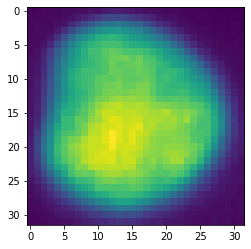

In [9]:
import matplotlib.pyplot as plt

# Got one that is not on the border
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][4])
plt.savefig('../poster_images/reconstruction_images/resized/resized_original_image.jpeg')

In [10]:
def get_reconstructed_img(batch, frame, cell):
    # Should create 'data' beforehand and store as variable
    ############################################################################################################
    appearances = track_info['appearances']

    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

    # Normalize appearances
    appearances = norm(appearances)

    input_dict = {'appearances': appearances}

    output_dict = {'appearances_decoder': appearances}

    data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

    data = data.repeat().batch(1)
    ############################################################################################################
    
    it = iter(data)

    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    cell_num = shape[2] * batch + cell + 1

    for cell in range(cell_num):
        nxt = it.next()
    
    inputs = nxt[0]['appearances']
    app_encoded = app_encoder(inputs)
    embeddings = embedding_model(app_encoded)
    reconstructions = app_decoder(embeddings)
    img_reconstruction = reconstructions[0][frame].numpy().astype('float32')
    
    return img_reconstruction

In [11]:
reconstructed_img = get_reconstructed_img(0, 0, 4)

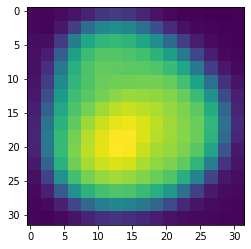

In [12]:
fig, ax = plt.subplots()
ax.imshow(reconstructed_img)
plt.savefig('../poster_images/reconstruction_images/resized/resized_recon_image.jpeg')